
 8
[torch.LongTensor of size 1]



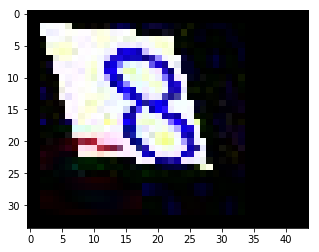

In [121]:
import torch
import torchvision
from torchvision import transforms 
from torchvision import datasets
import torch.utils.data as data
from PIL import Image
from matplotlib import pyplot as plt


%matplotlib inline

def default_loader(path):
    return Image.open(path).convert('RGB')

class MyImageLoader(data.Dataset):
    def __init__(self, root, label, transform = None, target_transform=None, loader=default_loader):
        self.imgs = []
        with open(label) as f:
            for i in f:
                dt = i.split("\t")
                self.imgs.append((dt[0],int(dt[1])))
                            
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader
    
    def __getitem__(self, index):
        fname, label = self.imgs[index]
        img = plt.imread(self.root + fname)
        if self.transform is not None:
            img = self.transform(img)
        return img, label
        #return img, torch.Tensor(label)
    
    def __len__(self):
        return len(self.imgs)

#myImageLoader = MyImageLoader(root = "./data/captcha/data/",label="./data/captcha/label.txt")
#len(myImageLoader)

train_loader = torch.utils.data.DataLoader(
         MyImageLoader(root = "./data/captcha/",label="./data/captcha/train_label.txt",transform = transforms.Compose([transforms.ToTensor()])))


import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

def imshow(img):
    #img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))

    #plt.imshow(np.transpose(npimg, (1,2,0)))

tLoader = iter(train_loader)
images, labels = tLoader.next()
print(labels)
#print(images)
imshow(torchvision.utils.make_grid(images))


In [119]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable

has_cuda = False
kwargs = {'num_workers': 1, 'pin_memory': True} if has_cuda else {}


#class Net(nn.Module):
#    def __init__(self):
#        super(Net, self).__init__()
#        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
#        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
#        self.conv2_drop = nn.Dropout2d()
#        self.fc1 = nn.Linear(320, 50)
#        self.fc2 = nn.Linear(50, 10)
#
#    def forward(self, x):
#        x = F.relu(F.max_pool2d(self.conv1(x), 2))
#        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
#        x = x.view(-1, 320)
#        x = F.relu(self.fc1(x))
#        x = F.dropout(x, training=self.training)
#        x = self.fc2(x)
#        return F.log_softmax(x)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2))
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(32, 64, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.conv3 = torch.nn.Sequential(
            torch.nn.Conv2d(64, 64, 3, 1, 1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2)
        )
        self.dense = torch.nn.Sequential(
            torch.nn.Linear(64 * 3 * 3, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 10)
        )

    def forward(self, x):
        conv1_out = self.conv1(x)
        conv2_out = self.conv2(conv1_out)
        conv3_out = self.conv3(conv2_out)
        res = conv3_out.view(conv3_out.size(0), -1)
        out = self.dense(res)
        return out    
    
    
    
    
model = Net()    
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

def train(epoch):
    model.train()#把module设成training模式，对Dropout和BatchNorm有影响
    for batch_idx, (data, target) in enumerate(train_loader):
        if has_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)#Variable类对Tensor对象进行封装，会保存该张量对应的梯度，以及对生成该张量的函数grad_fn的一个引用。如果该张量是用户创建的，grad_fn是None，称这样的Variable为叶子Variable。
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)#负log似然损失
        loss.backward()
        optimizer.step()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

def test(epoch):
    model.eval()#把module设置为评估模式，只对Dropout和BatchNorm模块有影响
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if has_cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += F.nll_loss(output, target).data[0]#Variable.data
        pred = output.data.max(1)[1] # get the index of the max log-probability
        print(output.data)
        correct += pred.eq(target.data).cpu().sum()
        #print(target.data)
    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
for epoch in range(1, 11):
    train(epoch)
    print("训练完成，进行测试")
    #test(epoch)
    print("测试结束，下一轮训练开始 %d" % epoch)
print("运行结束")

RuntimeError: size mismatch, m1: [1 x 960], m2: [576 x 128] at /pytorch/torch/lib/TH/generic/THTensorMath.c:1416